In [1]:
import os
import pandas as pd
import torch
import anndata as ad
from torch_geometric.loader import DataLoader
import scanpy as sc
from scregat.data_process import prepare_model_input,sum_counts,plot_edge, ATACGraphDataset
import numpy as np
from scregat.model import train_scregat, explain_model_ig
import pickle

In [2]:
import pickle
with open('./dataset_atac.pkl', 'rb') as f:
    dataset_atac = pickle.load(f)
dataset_graph = ATACGraphDataset('./input_graph/')

In [4]:
test_cell = pd.read_csv('./test_cell_name.txt')['x'].values

In [6]:
#import os
import pandas as pd
import torch
import anndata as ad
from torch_geometric.loader import DataLoader
import scanpy as sc
from scregat.data_process import prepare_model_input,sum_counts,plot_edge, ATACGraphDataset
import numpy as np
import pickle
import random
from tqdm import tqdm

seq_vec = torch.load('./seq.pth')

data = dataset_atac.array_peak
torch_vector = torch.zeros(len(data))
for idx, item in enumerate(data):
    if item.startswith('chr'):
        torch_vector[idx] = 0 
    else:
        torch_vector[idx] = 1 
train_graph = []
test_graph = []
test_cell_type = []
train_cell_type = []
for i, sample in tqdm(enumerate(dataset_graph), total=len(dataset_graph), desc='Processing samples'):

    seq_data = seq_vec
    sample.seq_data = seq_data
    sample.id_vec = torch_vector

    
    if sample.cell in test_cell:
        test_graph.append(sample)
        test_cell_type.append(sample.y.item())
    else:
        train_graph.append(sample)
        train_cell_type.append(sample.y.item())



Processing samples: 100%|██████████| 8821/8821 [00:03<00:00, 2828.54it/s]


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class SCReGAT(torch.nn.Module):
    def __init__(self,
                 node_input_dim=2,
                 node_output_dim=8,
                 edge_embedding_dim=8,
                 hidden_channels=16,  # 增加 hidden_channels
                 gat_input_channels=8,
                 gat_hidden_channels=8,  # 增加 GAT 隐藏通道
                 seq_dim=768,
                 seq2node_dim=1,
                 max_tokens=1024,
                 dropout=0.4,  # 增加 dropout
                 num_head_1=16,  # 增加 GAT 头数
                 num_head_2=16):  # 增加 GAT 头数
        super(SCReGAT, self).__init__()

        # Sequence transformation layer (currently commented out in forward)
        self.NN_seq = nn.Sequential(
            nn.Linear(seq_dim, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(),
            nn.Linear(512, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, seq2node_dim),
        )

        # Node feature transformation with BatchNorm
        self.NN_node = nn.Sequential(
            nn.Linear(node_input_dim, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(),
            nn.Linear(64, node_output_dim),
        )

        # Edge feature transformation with BatchNorm
        self.NN_edge = nn.Sequential(
            nn.Linear(1, 12),
            nn.LayerNorm(12),
            nn.LeakyReLU(),
            nn.Linear(12, edge_embedding_dim),
            nn.LeakyReLU()
        )

        # GAT layers with increased heads and self-loops
        self.NN_conv1 = GATConv(node_output_dim, hidden_channels, heads=num_head_1, dropout=dropout, edge_dim=edge_embedding_dim, add_self_loops=False)
        self.NN_flatten1 = nn.Linear(num_head_1 * hidden_channels, hidden_channels)

        self.NN_conv2 = GATConv(hidden_channels, hidden_channels, heads=num_head_2, dropout=dropout, add_self_loops=False)
        self.NN_flatten2 = nn.Linear(num_head_2 * hidden_channels, hidden_channels)

        self.dropout = nn.Dropout(0.2)  
        self.relu = nn.ReLU()
        self.leaky = nn.LeakyReLU()
        
        self.NN_cell_type = nn.Sequential(
            nn.Linear(1882, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(),
            nn.Linear(64, 9),
            nn.Softmax()
        )
        

    def forward(self, seq_data, raw_x, edge_index, edge_tf, batch, gene_num):
        data = raw_x
        seq_data = self.NN_seq(seq_data)
        data = torch.cat((data, seq_data), dim=1)
        data = self.NN_node(data)
        
        hidden_edge_input = raw_x[edge_index[0]] * raw_x[edge_index[1]]
        hidden_edge = self.NN_edge(hidden_edge_input).sigmoid()
        model.edge = torch.median(hidden_edge, dim=1)[0]
        data, atten_w1 = self.NN_conv1(data, edge_index, edge_attr=hidden_edge, return_attention_weights=True)
        data_1 = self.leaky(self.NN_flatten1(data))

        data_2, atten_w2 = self.NN_conv2(data_1, edge_tf, return_attention_weights=True)
        data_2 = self.leaky(self.NN_flatten2(data_2))
        
        data = data_1 + data_2
        self.data = data
        cell_type = self.NN_cell_type(torch.mean(data[:gene_num], dim=1))
        gene_out = -F.log_softmax(data[:gene_num], dim=1)[:, 0]
        return gene_out, atten_w1, cell_type

import torch
import torch.nn as nn

In [17]:
model = SCReGAT()

In [18]:
non_chr_peaks = [t for t in dataset_atac.array_peak if not t.startswith('chr')]
len(non_chr_peaks)

1882

In [20]:
import torch
import torch.nn as nn

class EdgeSparsityLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, gamma=5.0, threshold=0.1):
        """
        自定义稀疏性损失函数
        :param alpha: 控制L1稀疏正则化的权重
        :param beta: 控制高权重边的激励
        :param gamma: 控制阈值惩罚的权重
        :param threshold: 边权重的阈值，小于该值的边将受到额外惩罚
        """
        super(EdgeSparsityLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.threshold = threshold

    def forward(self, edge_weights):
        """
        计算自定义稀疏性损失
        :param edge_weights: 模型生成的边权重向量 (torch.Tensor)
        :return: 计算出的稀疏性损失 (torch.Tensor)
        """
        # L1 正则化：鼓励稀疏性
        sparsity_loss = self.alpha * torch.sum(torch.abs(edge_weights))

        # 高权重激励：放大较大的权重
        amplification_loss = -self.beta * torch.sum(torch.log(edge_weights + 1e-6))

        # 阈值惩罚：将小于阈值的边权重推向 0
        threshold_mask = edge_weights < self.threshold
        threshold_penalty = self.gamma * torch.sum(torch.pow(edge_weights[threshold_mask], 2))

        # 总损失：稀疏性、激励和阈值惩罚的组合
        loss = sparsity_loss + amplification_loss + threshold_penalty
        return loss


In [21]:
len(dataset_atac.array_celltype)

9

In [22]:
import torch
import random
from tqdm import tqdm

gene_num = len(sample.y_exp)
device = 'cuda:0'
model.to(device)
loss_exp = torch.nn.KLDivLoss(reduction='batchmean')
# loss_exp = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epoch = 200
drop_edge_rate = 0.1
attention_reg_weight = 0.01
sparse_loss_weight = 0.0001
batch_size = 1
criterion_sparse = EdgeSparsityLoss(alpha=1.0, beta=1.0, gamma=5.0, threshold=0.1)
criterion2 = torch.nn.CrossEntropyLoss()
max_grad_norm = 1.0

def drop_edges(edge_index, drop_rate=0.1):
    """随机丢弃边，依据设定的丢弃比例。
    Args:
        edge_index (torch.Tensor): 边的张量，形状为 (2, num_edges)。
        drop_rate (float): 要丢弃的边的比例。
    Returns:
        torch.Tensor: 丢弃部分边后的 edge_index。
    """
    num_edges = edge_index.size(1)
    mask = torch.rand(num_edges) > drop_rate
    return edge_index[:, mask]

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    running_loss1 = 0.0
    running_attention_loss = 0.0  # 记录 attention 正则化损失
    running_sparse_loss = 0.0  # 记录稀疏损失
    running_cell_loss = 0.0  # 记录 loss_cell

    random.shuffle(train_graph)
    train_loader = DataLoader(train_graph[:200], batch_size=batch_size, shuffle=True)
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epoch}", unit="batch")
    for idx, sample in enumerate(progress_bar):
        gene_num = sample.y_exp.shape[0]
        optimizer.zero_grad()
        edge_index_dropped = sample.edge_index
        gene_pre, atten, cell_pre = model(
            sample.seq_data.to(device),
            sample.x.to(device),
            sample.edge_index.to(device),
            sample.edge_tf.T.to(device),
            sample.batch.to(device), gene_num
        )
        index = torch.where(sample.id_vec == 1)[0]
        loss1 = -loss_exp(gene_pre.flatten(), sample.y_exp.to(device))
        loss_cell = criterion2(cell_pre.unsqueeze(0), sample.y.to(device))
        attention_variance = torch.var(atten[1], dim=1).mean()
        attention_loss = attention_reg_weight * (3.0 - attention_variance)  # 鼓励方差
        edge_temp = model.edge.flatten()
        loss2 = sparse_loss_weight * criterion_sparse(edge_temp)
        loss = loss1 + attention_loss + loss_cell + loss2
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        # 更新运行中的损失
        running_loss += loss.item()
        running_loss1 += loss1.item()
        running_attention_loss += attention_loss.item()  # 记录注意力正则化损失
        running_sparse_loss += loss2.item()  # 记录稀疏损失
        running_cell_loss += loss_cell.item()  # 记录 loss_cell

        # 更新进度条，显示平均损失
        progress_bar.set_postfix(
            loss=running_loss / (progress_bar.n + 1),
            loss1=running_loss1 / (progress_bar.n + 1),
            attention_loss=running_attention_loss / (progress_bar.n + 1),
            sparse_loss=running_sparse_loss / (progress_bar.n + 1),
            cell_loss=running_cell_loss / (progress_bar.n + 1)
        )

        # 清空 CUDA 缓存，管理显存
        torch.cuda.empty_cache()

    print(f"Epoch [{epoch+1}/{num_epoch}], Average Loss: {running_loss / len(train_loader):.4f}, "
          f"Loss1: {running_loss1 / len(train_loader):.4f}, Attention Loss: {running_attention_loss / len(train_loader):.4f}, "
          f"Sparse Loss: {running_sparse_loss / len(train_loader):.4f}, Cell Loss: {running_cell_loss / len(train_loader):.4f}")


Epoch 1/200: 100%|██████████| 200/200 [01:08<00:00,  2.94batch/s, attention_loss=0.03, cell_loss=2.2, loss=33, loss1=0.00406, sparse_loss=30.8]  


Epoch [1/200], Average Loss: 32.9970, Loss1: 0.0041, Attention Loss: 0.0300, Sparse Loss: 30.7605, Cell Loss: 2.2025


Epoch 2/200: 100%|██████████| 200/200 [01:06<00:00,  3.01batch/s, attention_loss=0.03, cell_loss=2.2, loss=32.3, loss1=0.00372, sparse_loss=30.1]


Epoch [2/200], Average Loss: 32.3267, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 30.0938, Cell Loss: 2.1992


Epoch 3/200: 100%|██████████| 200/200 [01:08<00:00,  2.91batch/s, attention_loss=0.03, cell_loss=2.2, loss=32.1, loss1=0.00414, sparse_loss=29.9] 


Epoch [3/200], Average Loss: 32.1496, Loss1: 0.0041, Attention Loss: 0.0300, Sparse Loss: 29.9141, Cell Loss: 2.2014


Epoch 4/200: 100%|██████████| 200/200 [01:06<00:00,  3.01batch/s, attention_loss=0.03, cell_loss=2.19, loss=32.1, loss1=0.0052, sparse_loss=29.9] 


Epoch [4/200], Average Loss: 32.0985, Loss1: 0.0052, Attention Loss: 0.0300, Sparse Loss: 29.8734, Cell Loss: 2.1898


Epoch 5/200: 100%|██████████| 200/200 [01:07<00:00,  2.97batch/s, attention_loss=0.03, cell_loss=2.01, loss=31.9, loss1=0.0052, sparse_loss=29.9] 


Epoch [5/200], Average Loss: 31.9078, Loss1: 0.0052, Attention Loss: 0.0300, Sparse Loss: 29.8591, Cell Loss: 2.0135


Epoch 6/200: 100%|██████████| 200/200 [01:06<00:00,  3.00batch/s, attention_loss=0.03, cell_loss=1.73, loss=31.6, loss1=0.00531, sparse_loss=29.9]


Epoch [6/200], Average Loss: 31.6220, Loss1: 0.0053, Attention Loss: 0.0300, Sparse Loss: 29.8533, Cell Loss: 1.7333


Epoch 7/200: 100%|██████████| 200/200 [01:07<00:00,  2.97batch/s, attention_loss=0.03, cell_loss=1.63, loss=31.5, loss1=0.00524, sparse_loss=29.8]


Epoch [7/200], Average Loss: 31.5111, Loss1: 0.0052, Attention Loss: 0.0300, Sparse Loss: 29.8493, Cell Loss: 1.6266


Epoch 8/200: 100%|██████████| 200/200 [01:06<00:00,  2.99batch/s, attention_loss=0.03, cell_loss=1.57, loss=31.5, loss1=0.00511, sparse_loss=29.8]


Epoch [8/200], Average Loss: 31.4562, Loss1: 0.0051, Attention Loss: 0.0300, Sparse Loss: 29.8462, Cell Loss: 1.5749


Epoch 9/200: 100%|██████████| 200/200 [01:07<00:00,  2.98batch/s, attention_loss=0.03, cell_loss=1.56, loss=31.4, loss1=0.00409, sparse_loss=29.8]


Epoch [9/200], Average Loss: 31.4340, Loss1: 0.0041, Attention Loss: 0.0300, Sparse Loss: 29.8440, Cell Loss: 1.5559


Epoch 10/200: 100%|██████████| 200/200 [01:06<00:00,  3.00batch/s, attention_loss=0.03, cell_loss=1.51, loss=31.4, loss1=0.00379, sparse_loss=29.8]


Epoch [10/200], Average Loss: 31.3912, Loss1: 0.0038, Attention Loss: 0.0300, Sparse Loss: 29.8425, Cell Loss: 1.5150


Epoch 11/200: 100%|██████████| 200/200 [01:07<00:00,  2.97batch/s, attention_loss=0.03, cell_loss=1.53, loss=31.4, loss1=0.00375, sparse_loss=29.8]


Epoch [11/200], Average Loss: 31.4068, Loss1: 0.0038, Attention Loss: 0.0300, Sparse Loss: 29.8412, Cell Loss: 1.5318


Epoch 12/200: 100%|██████████| 200/200 [01:05<00:00,  3.05batch/s, attention_loss=0.03, cell_loss=1.5, loss=31.4, loss1=0.00378, sparse_loss=29.8] 


Epoch [12/200], Average Loss: 31.3721, Loss1: 0.0038, Attention Loss: 0.0300, Sparse Loss: 29.8404, Cell Loss: 1.4980


Epoch 13/200: 100%|██████████| 200/200 [01:06<00:00,  3.00batch/s, attention_loss=0.03, cell_loss=1.5, loss=31.4, loss1=0.00374, sparse_loss=29.8] 


Epoch [13/200], Average Loss: 31.3772, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8397, Cell Loss: 1.5037


Epoch 14/200: 100%|██████████| 200/200 [01:07<00:00,  2.96batch/s, attention_loss=0.03, cell_loss=1.49, loss=31.4, loss1=0.00373, sparse_loss=29.8]


Epoch [14/200], Average Loss: 31.3602, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8393, Cell Loss: 1.4873


Epoch 15/200: 100%|██████████| 200/200 [01:06<00:00,  2.99batch/s, attention_loss=0.03, cell_loss=1.5, loss=31.4, loss1=0.00376, sparse_loss=29.8] 


Epoch [15/200], Average Loss: 31.3679, Loss1: 0.0038, Attention Loss: 0.0300, Sparse Loss: 29.8389, Cell Loss: 1.4953


Epoch 16/200: 100%|██████████| 200/200 [01:07<00:00,  2.98batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00376, sparse_loss=29.8]


Epoch [16/200], Average Loss: 31.3162, Loss1: 0.0038, Attention Loss: 0.0300, Sparse Loss: 29.8386, Cell Loss: 1.4438


Epoch 17/200: 100%|██████████| 200/200 [01:05<00:00,  3.03batch/s, attention_loss=0.03, cell_loss=1.49, loss=31.4, loss1=0.00375, sparse_loss=29.8]


Epoch [17/200], Average Loss: 31.3577, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8383, Cell Loss: 1.4856


Epoch 18/200: 100%|██████████| 200/200 [01:06<00:00,  3.02batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00374, sparse_loss=29.8]


Epoch [18/200], Average Loss: 31.3073, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8382, Cell Loss: 1.4354


Epoch 19/200: 100%|██████████| 200/200 [01:08<00:00,  2.91batch/s, attention_loss=0.03, cell_loss=1.48, loss=31.4, loss1=0.00374, sparse_loss=29.8]


Epoch [19/200], Average Loss: 31.3536, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8380, Cell Loss: 1.4819


Epoch 20/200: 100%|██████████| 200/200 [01:15<00:00,  2.65batch/s, attention_loss=0.03, cell_loss=1.49, loss=31.4, loss1=0.00375, sparse_loss=29.8]


Epoch [20/200], Average Loss: 31.3625, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8379, Cell Loss: 1.4909


Epoch 21/200: 100%|██████████| 200/200 [01:17<00:00,  2.59batch/s, attention_loss=0.03, cell_loss=1.47, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [21/200], Average Loss: 31.3457, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8378, Cell Loss: 1.4742


Epoch 22/200: 100%|██████████| 200/200 [01:15<00:00,  2.66batch/s, attention_loss=0.03, cell_loss=1.46, loss=31.3, loss1=0.00375, sparse_loss=29.8]


Epoch [22/200], Average Loss: 31.3348, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8377, Cell Loss: 1.4634


Epoch 23/200: 100%|██████████| 200/200 [01:15<00:00,  2.66batch/s, attention_loss=0.03, cell_loss=1.47, loss=31.3, loss1=0.00375, sparse_loss=29.8]


Epoch [23/200], Average Loss: 31.3371, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8376, Cell Loss: 1.4657


Epoch 24/200: 100%|██████████| 200/200 [01:14<00:00,  2.70batch/s, attention_loss=0.03, cell_loss=1.51, loss=31.4, loss1=0.00374, sparse_loss=29.8]


Epoch [24/200], Average Loss: 31.3765, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8375, Cell Loss: 1.5052


Epoch 25/200: 100%|██████████| 200/200 [01:13<00:00,  2.73batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00374, sparse_loss=29.8]


Epoch [25/200], Average Loss: 31.3111, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8375, Cell Loss: 1.4399


Epoch 26/200: 100%|██████████| 200/200 [01:13<00:00,  2.71batch/s, attention_loss=0.03, cell_loss=1.48, loss=31.4, loss1=0.00373, sparse_loss=29.8]


Epoch [26/200], Average Loss: 31.3556, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8374, Cell Loss: 1.4844


Epoch 27/200: 100%|██████████| 200/200 [01:13<00:00,  2.74batch/s, attention_loss=0.03, cell_loss=1.47, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [27/200], Average Loss: 31.3369, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8374, Cell Loss: 1.4658


Epoch 28/200: 100%|██████████| 200/200 [01:16<00:00,  2.63batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00374, sparse_loss=29.8]


Epoch [28/200], Average Loss: 31.3157, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8374, Cell Loss: 1.4446


Epoch 29/200: 100%|██████████| 200/200 [01:13<00:00,  2.71batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [29/200], Average Loss: 31.3181, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8373, Cell Loss: 1.4470


Epoch 30/200: 100%|██████████| 200/200 [01:12<00:00,  2.74batch/s, attention_loss=0.03, cell_loss=1.48, loss=31.4, loss1=0.00373, sparse_loss=29.8]


Epoch [30/200], Average Loss: 31.3556, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8373, Cell Loss: 1.4845


Epoch 31/200: 100%|██████████| 200/200 [01:13<00:00,  2.72batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00374, sparse_loss=29.8]


Epoch [31/200], Average Loss: 31.3135, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8373, Cell Loss: 1.4424


Epoch 32/200: 100%|██████████| 200/200 [01:18<00:00,  2.54batch/s, attention_loss=0.03, cell_loss=1.46, loss=31.3, loss1=0.00374, sparse_loss=29.8]


Epoch [32/200], Average Loss: 31.3317, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8373, Cell Loss: 1.4607


Epoch 33/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00374, sparse_loss=29.8]


Epoch [33/200], Average Loss: 31.3098, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8373, Cell Loss: 1.4388


Epoch 34/200: 100%|██████████| 200/200 [01:18<00:00,  2.56batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [34/200], Average Loss: 31.3166, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8372, Cell Loss: 1.4457


Epoch 35/200: 100%|██████████| 200/200 [01:18<00:00,  2.55batch/s, attention_loss=0.03, cell_loss=1.48, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [35/200], Average Loss: 31.3483, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8372, Cell Loss: 1.4773


Epoch 36/200: 100%|██████████| 200/200 [01:18<00:00,  2.56batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [36/200], Average Loss: 31.3234, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8372, Cell Loss: 1.4525


Epoch 37/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=1.49, loss=31.4, loss1=0.00373, sparse_loss=29.8]


Epoch [37/200], Average Loss: 31.3582, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8372, Cell Loss: 1.4872


Epoch 38/200: 100%|██████████| 200/200 [01:17<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=1.43, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [38/200], Average Loss: 31.3045, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8372, Cell Loss: 1.4336


Epoch 39/200: 100%|██████████| 200/200 [01:16<00:00,  2.61batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [39/200], Average Loss: 31.3216, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8372, Cell Loss: 1.4507


Epoch 40/200: 100%|██████████| 200/200 [01:16<00:00,  2.62batch/s, attention_loss=0.03, cell_loss=1.47, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [40/200], Average Loss: 31.3452, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8372, Cell Loss: 1.4743


Epoch 41/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [41/200], Average Loss: 31.3254, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8372, Cell Loss: 1.4545


Epoch 42/200: 100%|██████████| 200/200 [01:18<00:00,  2.55batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [42/200], Average Loss: 31.3151, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8372, Cell Loss: 1.4442


Epoch 43/200: 100%|██████████| 200/200 [01:17<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [43/200], Average Loss: 31.3071, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8372, Cell Loss: 1.4362


Epoch 44/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [44/200], Average Loss: 31.3113, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8372, Cell Loss: 1.4404


Epoch 45/200: 100%|██████████| 200/200 [01:15<00:00,  2.64batch/s, attention_loss=0.03, cell_loss=1.51, loss=31.4, loss1=0.00373, sparse_loss=29.8]


Epoch [45/200], Average Loss: 31.3845, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8372, Cell Loss: 1.5136


Epoch 46/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [46/200], Average Loss: 31.3254, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8372, Cell Loss: 1.4546


Epoch 47/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=1.46, loss=31.3, loss1=0.00374, sparse_loss=29.8]


Epoch [47/200], Average Loss: 31.3288, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8372, Cell Loss: 1.4579


Epoch 48/200: 100%|██████████| 200/200 [01:16<00:00,  2.61batch/s, attention_loss=0.03, cell_loss=1.49, loss=31.4, loss1=0.00373, sparse_loss=29.8]


Epoch [48/200], Average Loss: 31.3626, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4917


Epoch 49/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [49/200], Average Loss: 31.3061, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4353


Epoch 50/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=1.42, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [50/200], Average Loss: 31.2898, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4189


Epoch 51/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=1.43, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [51/200], Average Loss: 31.2980, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4272


Epoch 52/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=1.47, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [52/200], Average Loss: 31.3430, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4722


Epoch 53/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=1.43, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [53/200], Average Loss: 31.3019, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4310


Epoch 54/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=1.46, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [54/200], Average Loss: 31.3264, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4555


Epoch 55/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [55/200], Average Loss: 31.3098, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4389


Epoch 56/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [56/200], Average Loss: 31.3166, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4457


Epoch 57/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=1.43, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [57/200], Average Loss: 31.2992, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4284


Epoch 58/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=1.41, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [58/200], Average Loss: 31.2828, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4119


Epoch 59/200: 100%|██████████| 200/200 [01:18<00:00,  2.56batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [59/200], Average Loss: 31.3217, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4509


Epoch 60/200: 100%|██████████| 200/200 [01:16<00:00,  2.63batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [60/200], Average Loss: 31.3133, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4425


Epoch 61/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=1.42, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [61/200], Average Loss: 31.2865, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4157


Epoch 62/200: 100%|██████████| 200/200 [01:17<00:00,  2.59batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [62/200], Average Loss: 31.3122, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4413


Epoch 63/200: 100%|██████████| 200/200 [01:18<00:00,  2.56batch/s, attention_loss=0.03, cell_loss=1.46, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [63/200], Average Loss: 31.3281, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4572


Epoch 64/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=1.46, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [64/200], Average Loss: 31.3269, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4560


Epoch 65/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=1.48, loss=31.4, loss1=0.00374, sparse_loss=29.8]


Epoch [65/200], Average Loss: 31.3507, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4798


Epoch 66/200: 100%|██████████| 200/200 [01:18<00:00,  2.56batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [66/200], Average Loss: 31.3163, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4454


Epoch 67/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [67/200], Average Loss: 31.3111, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4403


Epoch 68/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=1.43, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [68/200], Average Loss: 31.3026, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4317


Epoch 69/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=1.5, loss=31.4, loss1=0.00373, sparse_loss=29.8] 


Epoch [69/200], Average Loss: 31.3667, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4958


Epoch 70/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=2.28, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [70/200], Average Loss: 32.1478, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2770


Epoch 71/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=2.27, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [71/200], Average Loss: 32.1428, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2720


Epoch 72/200: 100%|██████████| 200/200 [01:16<00:00,  2.61batch/s, attention_loss=0.03, cell_loss=2.25, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [72/200], Average Loss: 32.1178, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2470


Epoch 73/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=2.24, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [73/200], Average Loss: 32.1128, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2420


Epoch 74/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=2.28, loss=32.2, loss1=0.00372, sparse_loss=29.8]


Epoch [74/200], Average Loss: 32.1528, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2820


Epoch 75/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=2.21, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [75/200], Average Loss: 32.0828, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2120


Epoch 76/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=2.28, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [76/200], Average Loss: 32.1478, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2770


Epoch 77/200: 100%|██████████| 200/200 [01:18<00:00,  2.53batch/s, attention_loss=0.03, cell_loss=2.2, loss=32.1, loss1=0.00372, sparse_loss=29.8] 


Epoch [77/200], Average Loss: 32.0678, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.1970


Epoch 78/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=2.26, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [78/200], Average Loss: 32.1278, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2570


Epoch 79/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=2.27, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [79/200], Average Loss: 32.1428, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2720


Epoch 80/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=2.29, loss=32.2, loss1=0.00372, sparse_loss=29.8]


Epoch [80/200], Average Loss: 32.1578, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2870


Epoch 81/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=2.28, loss=32.1, loss1=0.00373, sparse_loss=29.8]


Epoch [81/200], Average Loss: 32.1478, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2770


Epoch 82/200: 100%|██████████| 200/200 [01:15<00:00,  2.63batch/s, attention_loss=0.03, cell_loss=2.26, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [82/200], Average Loss: 32.1328, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2620


Epoch 83/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=2.29, loss=32.2, loss1=0.00372, sparse_loss=29.8]


Epoch [83/200], Average Loss: 32.1628, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2920


Epoch 84/200: 100%|██████████| 200/200 [01:18<00:00,  2.56batch/s, attention_loss=0.03, cell_loss=2.24, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [84/200], Average Loss: 32.1128, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2420


Epoch 85/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=2.24, loss=32.1, loss1=0.00371, sparse_loss=29.8]


Epoch [85/200], Average Loss: 32.1078, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2370


Epoch 86/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=2.24, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [86/200], Average Loss: 32.1078, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2370


Epoch 87/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=2.26, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [87/200], Average Loss: 32.1278, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2570


Epoch 88/200: 100%|██████████| 200/200 [01:16<00:00,  2.61batch/s, attention_loss=0.03, cell_loss=2.23, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [88/200], Average Loss: 32.1028, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2320


Epoch 89/200: 100%|██████████| 200/200 [01:17<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=2.26, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [89/200], Average Loss: 32.1278, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2570


Epoch 90/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=2.25, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [90/200], Average Loss: 32.1228, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2520


Epoch 91/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=2.27, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [91/200], Average Loss: 32.1378, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2670


Epoch 92/200: 100%|██████████| 200/200 [01:16<00:00,  2.61batch/s, attention_loss=0.03, cell_loss=2.29, loss=32.2, loss1=0.00372, sparse_loss=29.8]


Epoch [92/200], Average Loss: 32.1628, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2920


Epoch 93/200: 100%|██████████| 200/200 [01:16<00:00,  2.61batch/s, attention_loss=0.03, cell_loss=2.25, loss=32.1, loss1=0.00371, sparse_loss=29.8]


Epoch [93/200], Average Loss: 32.1178, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2470


Epoch 94/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=2.25, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [94/200], Average Loss: 32.1228, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2520


Epoch 95/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=2.28, loss=32.2, loss1=0.00373, sparse_loss=29.8]


Epoch [95/200], Average Loss: 32.1528, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2820


Epoch 96/200: 100%|██████████| 200/200 [01:16<00:00,  2.62batch/s, attention_loss=0.03, cell_loss=2.25, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [96/200], Average Loss: 32.1228, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2520


Epoch 97/200: 100%|██████████| 200/200 [01:16<00:00,  2.61batch/s, attention_loss=0.03, cell_loss=2.25, loss=32.1, loss1=0.00371, sparse_loss=29.8]


Epoch [97/200], Average Loss: 32.1178, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2470


Epoch 98/200: 100%|██████████| 200/200 [01:18<00:00,  2.56batch/s, attention_loss=0.03, cell_loss=2.25, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [98/200], Average Loss: 32.1228, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2520


Epoch 99/200: 100%|██████████| 200/200 [01:17<00:00,  2.59batch/s, attention_loss=0.03, cell_loss=2.23, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [99/200], Average Loss: 32.0978, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2270


Epoch 100/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=2.24, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [100/200], Average Loss: 32.1078, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2370


Epoch 101/200: 100%|██████████| 200/200 [01:18<00:00,  2.55batch/s, attention_loss=0.03, cell_loss=2.25, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [101/200], Average Loss: 32.1228, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2520


Epoch 102/200: 100%|██████████| 200/200 [01:17<00:00,  2.59batch/s, attention_loss=0.03, cell_loss=2.26, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [102/200], Average Loss: 32.1278, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2570


Epoch 103/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=2.27, loss=32.1, loss1=0.00372, sparse_loss=29.8]


Epoch [103/200], Average Loss: 32.1378, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2670


Epoch 104/200: 100%|██████████| 200/200 [01:18<00:00,  2.56batch/s, attention_loss=0.03, cell_loss=2.29, loss=32.2, loss1=0.00372, sparse_loss=29.8]


Epoch [104/200], Average Loss: 32.1628, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2920


Epoch 105/200: 100%|██████████| 200/200 [01:18<00:00,  2.56batch/s, attention_loss=0.03, cell_loss=2.3, loss=32.2, loss1=0.00372, sparse_loss=29.8] 


Epoch [105/200], Average Loss: 32.1678, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.2970


Epoch 106/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=2.04, loss=31.9, loss1=0.00421, sparse_loss=29.8]


Epoch [106/200], Average Loss: 31.9111, Loss1: 0.0042, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 2.0398


Epoch 107/200: 100%|██████████| 200/200 [01:17<00:00,  2.59batch/s, attention_loss=0.03, cell_loss=1.49, loss=31.4, loss1=0.00486, sparse_loss=29.8]


Epoch [107/200], Average Loss: 31.3629, Loss1: 0.0049, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4909


Epoch 108/200: 100%|██████████| 200/200 [01:18<00:00,  2.53batch/s, attention_loss=0.03, cell_loss=1.49, loss=31.4, loss1=0.00429, sparse_loss=29.8]


Epoch [108/200], Average Loss: 31.3584, Loss1: 0.0043, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4870


Epoch 109/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=1.46, loss=31.3, loss1=0.00399, sparse_loss=29.8]


Epoch [109/200], Average Loss: 31.3324, Loss1: 0.0040, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4613


Epoch 110/200: 100%|██████████| 200/200 [01:17<00:00,  2.59batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00376, sparse_loss=29.8]


Epoch [110/200], Average Loss: 31.3182, Loss1: 0.0038, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4473


Epoch 111/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=1.43, loss=31.3, loss1=0.00375, sparse_loss=29.8]


Epoch [111/200], Average Loss: 31.3002, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4294


Epoch 112/200: 100%|██████████| 200/200 [01:17<00:00,  2.59batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00377, sparse_loss=29.8]


Epoch [112/200], Average Loss: 31.3157, Loss1: 0.0038, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4449


Epoch 113/200: 100%|██████████| 200/200 [01:16<00:00,  2.62batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [113/200], Average Loss: 31.3233, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4525


Epoch 114/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=1.46, loss=31.3, loss1=0.00377, sparse_loss=29.8]


Epoch [114/200], Average Loss: 31.3281, Loss1: 0.0038, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4572


Epoch 115/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=1.46, loss=31.3, loss1=0.00374, sparse_loss=29.8]


Epoch [115/200], Average Loss: 31.3302, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4593


Epoch 116/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=1.46, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [116/200], Average Loss: 31.3287, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4579


Epoch 117/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [117/200], Average Loss: 31.3144, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4436


Epoch 118/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [118/200], Average Loss: 31.3131, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4422


Epoch 119/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [119/200], Average Loss: 31.3126, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4418


Epoch 120/200: 100%|██████████| 200/200 [01:18<00:00,  2.56batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [120/200], Average Loss: 31.3104, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4396


Epoch 121/200: 100%|██████████| 200/200 [01:18<00:00,  2.56batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00375, sparse_loss=29.8]


Epoch [121/200], Average Loss: 31.3173, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4464


Epoch 122/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=1.47, loss=31.3, loss1=0.00375, sparse_loss=29.8]


Epoch [122/200], Average Loss: 31.3367, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4658


Epoch 123/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=1.48, loss=31.4, loss1=0.00384, sparse_loss=29.8]


Epoch [123/200], Average Loss: 31.3540, Loss1: 0.0038, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4830


Epoch 124/200: 100%|██████████| 200/200 [01:17<00:00,  2.59batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00376, sparse_loss=29.8]


Epoch [124/200], Average Loss: 31.3169, Loss1: 0.0038, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4460


Epoch 125/200: 100%|██████████| 200/200 [01:18<00:00,  2.54batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [125/200], Average Loss: 31.3072, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4364


Epoch 126/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=1.43, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [126/200], Average Loss: 31.3039, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4330


Epoch 127/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=1.46, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [127/200], Average Loss: 31.3261, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4552


Epoch 128/200: 100%|██████████| 200/200 [01:18<00:00,  2.55batch/s, attention_loss=0.03, cell_loss=1.42, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [128/200], Average Loss: 31.2908, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4200


Epoch 129/200: 100%|██████████| 200/200 [01:16<00:00,  2.61batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [129/200], Average Loss: 31.3067, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4358


Epoch 130/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=1.46, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [130/200], Average Loss: 31.3261, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4552


Epoch 131/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=1.43, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [131/200], Average Loss: 31.3054, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4345


Epoch 133/200: 100%|██████████| 200/200 [01:17<00:00,  2.59batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00374, sparse_loss=29.8]


Epoch [133/200], Average Loss: 31.3204, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4496


Epoch 134/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [134/200], Average Loss: 31.3078, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4370


Epoch 135/200: 100%|██████████| 200/200 [01:18<00:00,  2.56batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [135/200], Average Loss: 31.3128, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4420


Epoch 136/200: 100%|██████████| 200/200 [01:17<00:00,  2.59batch/s, attention_loss=0.03, cell_loss=1.42, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [136/200], Average Loss: 31.2921, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4212


Epoch 137/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=1.42, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [137/200], Average Loss: 31.2943, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4234


Epoch 138/200: 100%|██████████| 200/200 [01:16<00:00,  2.62batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [138/200], Average Loss: 31.3182, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4473


Epoch 139/200: 100%|██████████| 200/200 [01:15<00:00,  2.63batch/s, attention_loss=0.03, cell_loss=1.47, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [139/200], Average Loss: 31.3415, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4707


Epoch 140/200: 100%|██████████| 200/200 [01:16<00:00,  2.62batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [140/200], Average Loss: 31.3087, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4378


Epoch 141/200: 100%|██████████| 200/200 [01:16<00:00,  2.62batch/s, attention_loss=0.03, cell_loss=1.48, loss=31.4, loss1=0.00372, sparse_loss=29.8]


Epoch [141/200], Average Loss: 31.3501, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4792


Epoch 142/200: 100%|██████████| 200/200 [01:17<00:00,  2.59batch/s, attention_loss=0.03, cell_loss=1.51, loss=31.4, loss1=0.00374, sparse_loss=29.8]


Epoch [142/200], Average Loss: 31.3776, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.5067


Epoch 143/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=1.46, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [143/200], Average Loss: 31.3291, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4583


Epoch 144/200: 100%|██████████| 200/200 [01:16<00:00,  2.62batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [144/200], Average Loss: 31.3246, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4537


Epoch 145/200: 100%|██████████| 200/200 [01:17<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=1.42, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [145/200], Average Loss: 31.2930, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4221


Epoch 146/200: 100%|██████████| 200/200 [01:16<00:00,  2.61batch/s, attention_loss=0.03, cell_loss=1.41, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [146/200], Average Loss: 31.2825, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4117


Epoch 147/200: 100%|██████████| 200/200 [01:16<00:00,  2.61batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [147/200], Average Loss: 31.3125, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4416


Epoch 148/200: 100%|██████████| 200/200 [01:15<00:00,  2.64batch/s, attention_loss=0.03, cell_loss=1.47, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [148/200], Average Loss: 31.3426, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4718


Epoch 149/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [149/200], Average Loss: 31.3121, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4412


Epoch 150/200: 100%|██████████| 200/200 [01:16<00:00,  2.61batch/s, attention_loss=0.03, cell_loss=1.5, loss=31.4, loss1=0.00372, sparse_loss=29.8] 


Epoch [150/200], Average Loss: 31.3716, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.5008


Epoch 151/200: 100%|██████████| 200/200 [01:16<00:00,  2.61batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [151/200], Average Loss: 31.3106, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4398


Epoch 152/200: 100%|██████████| 200/200 [01:16<00:00,  2.61batch/s, attention_loss=0.03, cell_loss=1.46, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [152/200], Average Loss: 31.3275, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4566


Epoch 153/200: 100%|██████████| 200/200 [01:16<00:00,  2.61batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [153/200], Average Loss: 31.3117, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4408


Epoch 154/200: 100%|██████████| 200/200 [01:15<00:00,  2.65batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [154/200], Average Loss: 31.3165, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4456


Epoch 155/200: 100%|██████████| 200/200 [01:15<00:00,  2.64batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00375, sparse_loss=29.8]


Epoch [155/200], Average Loss: 31.3141, Loss1: 0.0038, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4432


Epoch 156/200: 100%|██████████| 200/200 [01:16<00:00,  2.63batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [156/200], Average Loss: 31.3235, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4526


Epoch 157/200: 100%|██████████| 200/200 [01:14<00:00,  2.70batch/s, attention_loss=0.03, cell_loss=1.43, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [157/200], Average Loss: 31.2979, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4271


Epoch 158/200: 100%|██████████| 200/200 [01:13<00:00,  2.74batch/s, attention_loss=0.03, cell_loss=1.46, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [158/200], Average Loss: 31.3336, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4628


Epoch 159/200: 100%|██████████| 200/200 [01:12<00:00,  2.74batch/s, attention_loss=0.03, cell_loss=1.47, loss=31.3, loss1=0.00374, sparse_loss=29.8]


Epoch [159/200], Average Loss: 31.3392, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4684


Epoch 160/200: 100%|██████████| 200/200 [01:13<00:00,  2.72batch/s, attention_loss=0.03, cell_loss=1.43, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [160/200], Average Loss: 31.2967, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4258


Epoch 161/200: 100%|██████████| 200/200 [01:14<00:00,  2.68batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [161/200], Average Loss: 31.3094, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4386


Epoch 162/200: 100%|██████████| 200/200 [01:14<00:00,  2.68batch/s, attention_loss=0.03, cell_loss=1.41, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [162/200], Average Loss: 31.2855, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4147


Epoch 163/200: 100%|██████████| 200/200 [01:16<00:00,  2.62batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00374, sparse_loss=29.8]


Epoch [163/200], Average Loss: 31.3072, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4364


Epoch 164/200: 100%|██████████| 200/200 [01:13<00:00,  2.71batch/s, attention_loss=0.03, cell_loss=1.41, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [164/200], Average Loss: 31.2761, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4052


Epoch 165/200: 100%|██████████| 200/200 [01:14<00:00,  2.68batch/s, attention_loss=0.03, cell_loss=1.49, loss=31.4, loss1=0.00373, sparse_loss=29.8]


Epoch [165/200], Average Loss: 31.3580, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4872


Epoch 166/200: 100%|██████████| 200/200 [01:12<00:00,  2.78batch/s, attention_loss=0.03, cell_loss=1.42, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [166/200], Average Loss: 31.2929, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4220


Epoch 167/200: 100%|██████████| 200/200 [01:14<00:00,  2.67batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [167/200], Average Loss: 31.3205, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4496


Epoch 168/200: 100%|██████████| 200/200 [01:12<00:00,  2.77batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [168/200], Average Loss: 31.3140, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4432


Epoch 169/200: 100%|██████████| 200/200 [01:04<00:00,  3.10batch/s, attention_loss=0.03, cell_loss=1.47, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [169/200], Average Loss: 31.3386, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4677


Epoch 170/200: 100%|██████████| 200/200 [01:04<00:00,  3.11batch/s, attention_loss=0.03, cell_loss=1.46, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [170/200], Average Loss: 31.3357, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4649


Epoch 171/200: 100%|██████████| 200/200 [01:06<00:00,  3.02batch/s, attention_loss=0.03, cell_loss=1.42, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [171/200], Average Loss: 31.2923, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4215


Epoch 172/200: 100%|██████████| 200/200 [01:13<00:00,  2.71batch/s, attention_loss=0.03, cell_loss=1.41, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [172/200], Average Loss: 31.2817, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4109


Epoch 173/200: 100%|██████████| 200/200 [01:13<00:00,  2.73batch/s, attention_loss=0.03, cell_loss=1.42, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [173/200], Average Loss: 31.2906, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4198


Epoch 174/200: 100%|██████████| 200/200 [01:13<00:00,  2.73batch/s, attention_loss=0.03, cell_loss=1.43, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [174/200], Average Loss: 31.2989, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4280


Epoch 175/200: 100%|██████████| 200/200 [01:17<00:00,  2.59batch/s, attention_loss=0.03, cell_loss=1.47, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [175/200], Average Loss: 31.3375, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4667


Epoch 176/200: 100%|██████████| 200/200 [01:23<00:00,  2.40batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [176/200], Average Loss: 31.3121, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4413


Epoch 177/200: 100%|██████████| 200/200 [01:18<00:00,  2.56batch/s, attention_loss=0.03, cell_loss=1.42, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [177/200], Average Loss: 31.2899, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4190


Epoch 178/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [178/200], Average Loss: 31.3179, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4470


Epoch 179/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=1.42, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [179/200], Average Loss: 31.2947, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4238


Epoch 180/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=1.46, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [180/200], Average Loss: 31.3326, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4618


Epoch 181/200: 100%|██████████| 200/200 [01:18<00:00,  2.56batch/s, attention_loss=0.03, cell_loss=1.49, loss=31.4, loss1=0.00372, sparse_loss=29.8]


Epoch [181/200], Average Loss: 31.3601, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4892


Epoch 182/200: 100%|██████████| 200/200 [02:00<00:00,  1.66batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [182/200], Average Loss: 31.3149, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4440


Epoch 183/200: 100%|██████████| 200/200 [03:48<00:00,  1.14s/batch, attention_loss=0.03, cell_loss=1.49, loss=31.4, loss1=0.00374, sparse_loss=29.8]


Epoch [183/200], Average Loss: 31.3642, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4933


Epoch 184/200: 100%|██████████| 200/200 [03:48<00:00,  1.14s/batch, attention_loss=0.03, cell_loss=1.48, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [184/200], Average Loss: 31.3499, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4791


Epoch 185/200: 100%|██████████| 200/200 [03:46<00:00,  1.13s/batch, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [185/200], Average Loss: 31.3121, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4413


Epoch 186/200: 100%|██████████| 200/200 [02:44<00:00,  1.22batch/s, attention_loss=0.03, cell_loss=1.42, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [186/200], Average Loss: 31.2867, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4159


Epoch 187/200: 100%|██████████| 200/200 [01:18<00:00,  2.55batch/s, attention_loss=0.03, cell_loss=1.41, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [187/200], Average Loss: 31.2818, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4109


Epoch 188/200: 100%|██████████| 200/200 [01:18<00:00,  2.56batch/s, attention_loss=0.03, cell_loss=1.41, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [188/200], Average Loss: 31.2844, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4136


Epoch 189/200: 100%|██████████| 200/200 [01:19<00:00,  2.52batch/s, attention_loss=0.03, cell_loss=1.46, loss=31.3, loss1=0.00374, sparse_loss=29.8]


Epoch [189/200], Average Loss: 31.3266, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4558


Epoch 190/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=1.44, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [190/200], Average Loss: 31.3144, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4436


Epoch 191/200: 100%|██████████| 200/200 [01:18<00:00,  2.56batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [191/200], Average Loss: 31.3212, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4503


Epoch 192/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=1.41, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [192/200], Average Loss: 31.2764, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4056


Epoch 193/200: 100%|██████████| 200/200 [01:17<00:00,  2.57batch/s, attention_loss=0.03, cell_loss=1.43, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [193/200], Average Loss: 31.3058, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4350


Epoch 194/200: 100%|██████████| 200/200 [01:19<00:00,  2.51batch/s, attention_loss=0.03, cell_loss=1.42, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [194/200], Average Loss: 31.2904, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4195


Epoch 195/200: 100%|██████████| 200/200 [01:16<00:00,  2.60batch/s, attention_loss=0.03, cell_loss=1.42, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [195/200], Average Loss: 31.2866, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4158


Epoch 196/200: 100%|██████████| 200/200 [01:17<00:00,  2.58batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [196/200], Average Loss: 31.3221, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4513


Epoch 197/200: 100%|██████████| 200/200 [01:18<00:00,  2.55batch/s, attention_loss=0.03, cell_loss=1.43, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [197/200], Average Loss: 31.3045, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4336


Epoch 198/200: 100%|██████████| 200/200 [01:19<00:00,  2.51batch/s, attention_loss=0.03, cell_loss=1.45, loss=31.3, loss1=0.00372, sparse_loss=29.8]


Epoch [198/200], Average Loss: 31.3196, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4488


Epoch 199/200: 100%|██████████| 200/200 [01:19<00:00,  2.52batch/s, attention_loss=0.03, cell_loss=1.43, loss=31.3, loss1=0.00373, sparse_loss=29.8]


Epoch [199/200], Average Loss: 31.2986, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4277


Epoch 200/200: 100%|██████████| 200/200 [01:18<00:00,  2.55batch/s, attention_loss=0.03, cell_loss=1.48, loss=31.3, loss1=0.00373, sparse_loss=29.8]

Epoch [200/200], Average Loss: 31.3473, Loss1: 0.0037, Attention Loss: 0.0300, Sparse Loss: 29.8371, Cell Loss: 1.4765


In [23]:
test_loader = DataLoader(test_graph, batch_size=1, shuffle=False, pin_memory=True)
model.eval()
test_loss = 0.0 

device = 'cuda:0'
model.to(device)

cell_type = []
test_barcodes = []
with torch.no_grad():
    cell_link_atten = []
    cell_link_activity = []
    cell_link_edge = []
    cell_link_enhancer = []
    for idx, sample in tqdm(enumerate(test_loader), total=len(test_loader), desc="Processing Batches"):
        gene_pre, atten, _ = model(sample.seq_data.to(device),
                                sample.x.to(device), 
                                sample.edge_index.to(device), 
                                sample.edge_tf.T.to(device), 
                                sample.batch.to(device), gene_num)
        test_barcodes.append(sample.cell)
        cell_type.append(sample.y.item())
        import torch

        # 对 model.edge.flatten() 进行 0-1 缩放
        edge_flattened = model.edge.flatten().to('cpu')
        min_val = torch.min(edge_flattened)
        max_val = torch.max(edge_flattened)
        normalized_edge = (edge_flattened - min_val) / (max_val - min_val + 1e-10)  # 防止除以 0

        # 将归一化后的张量添加到 cell_link_edge
        cell_link_edge.append(normalized_edge)


        flattened_sample_x = sample.to(device).x[atten[0][1].cpu()].flatten()
        flattened_sample_enhancer = sample.to(device).x[atten[0][0].cpu()].flatten()
        atten1_max = torch.mean(atten[1], dim=1).to('cpu')
        cell_link_activity.append(flattened_sample_x.to('cpu'))
        cell_link_atten.append(atten1_max)
        cell_link_enhancer.append(flattened_sample_enhancer.to('cpu'))
#         edges = model.edge.flatten().cpu().numpy()
        torch.cuda.empty_cache()

Processing Batches: 100%|██████████| 3529/3529 [17:32<00:00,  3.35it/s]


In [24]:
cell_link_atten = torch.stack(cell_link_atten)
cell_link_edge = torch.stack(cell_link_edge)
cell_link_activity = torch.stack(cell_link_activity)
cell_link_enhancer = torch.stack(cell_link_enhancer)

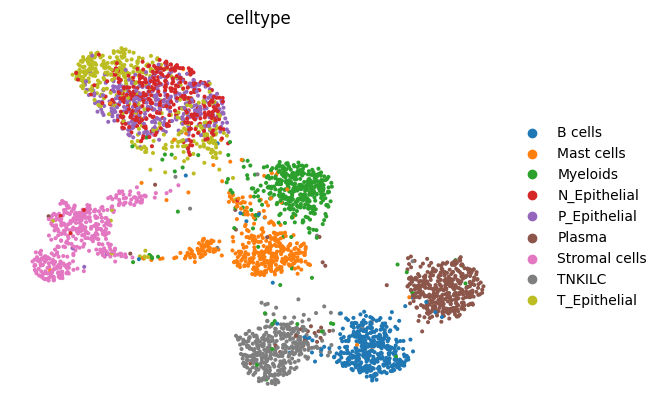

In [137]:
data_np = cell_link_activity.cpu().numpy()

import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[np.concatenate(test_barcodes)])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

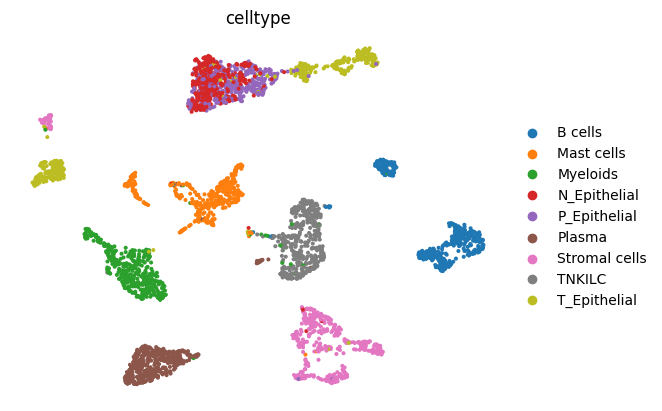

In [138]:
data_np = cell_link_enhancer.cpu().numpy()

import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[np.concatenate(test_barcodes)])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

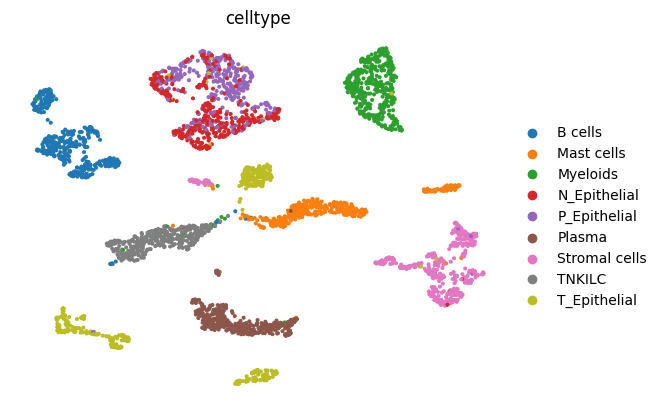

In [139]:
# Attention
data_np = cell_link_atten.cpu().numpy()

import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[np.concatenate(test_barcodes)])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

In [125]:
torch.save(cell_link_enhancer, 'cell_link_enhancer.pt')

In [123]:
torch.save(cell_link_atten, 'cell_link_atten.pt')

In [120]:
pd.read_csv('../test_fast/CRC_cellline_PO.txt', sep='\t', )

,chr1\t831895\t848168\tchr1:831895-848168\tUBE2J2
0,chr1\t831895\t848168\tchr1:831895-848168\tSAMD11
1,chr1\t848169\t850618\tchr1:848169-850618\tPUSL1
2,chr1\t848169\t850618\tchr1:848169-850618\tNOC2L
3,chr1\t848169\t850618\tchr1:848169-850618\tUBE2J2
4,chr1\t874082\t876091\tchr1:874082-876091\tSDF4
...,...
136820,chrY\t59014054\t59017708\tchrY:59014054-590177...
136821,chrY\t59017709\t59017981\tchrY:59017709-590179...
136822,chrY\t59017709\t59017981\tchrY:59017709-590179...
136823,chrY\t59017982\t59029526\tchrY:59017982-590295...


In [71]:
temp_df = pd.read_csv('../test_fast//intersect_CRC_cellline_link.txt')

# Define a function to clean up the gene and chromosome location
def clean_location(entry):
    # Remove any unwanted characters
    return entry.strip("')")

# Clean the index and data
temp_df['Gene'] = temp_df.index.str.strip("('")
temp_df['Location'] = temp_df['x'].apply(clean_location)

# Drop the original 'x' column
temp_df = temp_df.drop(columns=['x'])

# Display the cleaned DataFrame
print(temp_df.head())
gene_list = [t.split('\'')[-1] for t in temp_df['Gene'].values]
peak_list = [t.split('\'')[0] for t in temp_df['Location'].values]
df = pd.DataFrame({'gene':gene_list, 'peak':peak_list})
df.head()

                   Gene                     Location
1 "('A2M'      1 "('A2M     chr12-8709390-8709890')"
2 "('A2M'      2 "('A2M     chr12-8709390-8709890')"
3 "('ABCA1'  3 "('ABCA1  chr9-107918652-107919152')"
4 "('ABCA1'  4 "('ABCA1  chr9-107929677-107930177')"
5 "('ABCA1'  5 "('ABCA1  chr9-107999805-108000305')"


,gene,peak
0,A2M,chr12-8709390-8709890
1,A2M,chr12-8709390-8709890
2,ABCA1,chr9-107918652-107919152
3,ABCA1,chr9-107929677-107930177
4,ABCA1,chr9-107999805-108000305


In [73]:
pos_dict = dict()
pos_dict_int = dict()
for idx, t in enumerate(dataset_atac.array_peak):
    pos_dict[t] = idx
    pos_dict_int[idx] = t
    
str_lists = []
for t in range(atten[0].shape[1]):
    str_lists.append(pos_dict_int[atten[0][1][t].item()] +  '-'  + pos_dict_int[atten[0][0][t].item()]) 

In [74]:
target_links = []
for t in df.values:
    target_links.append(t[0] + '-' + t[1])

In [92]:
map_index = []
for t in target_links:
    try:
        map_index.append(str_lists.index(t))
    except:
        continue

In [100]:
map_index = torch.tensor(map_index)

In [85]:
cell_type_cpu = dataset_atac.adata.obs.loc[np.concatenate(test_barcodes)]['celltype'].values

In [87]:
unique_celltype = np.unique(cell_type), np.unique(cell_type_cpu, return_counts=True)

In [110]:
unique_celltype = dataset_atac.array_celltype

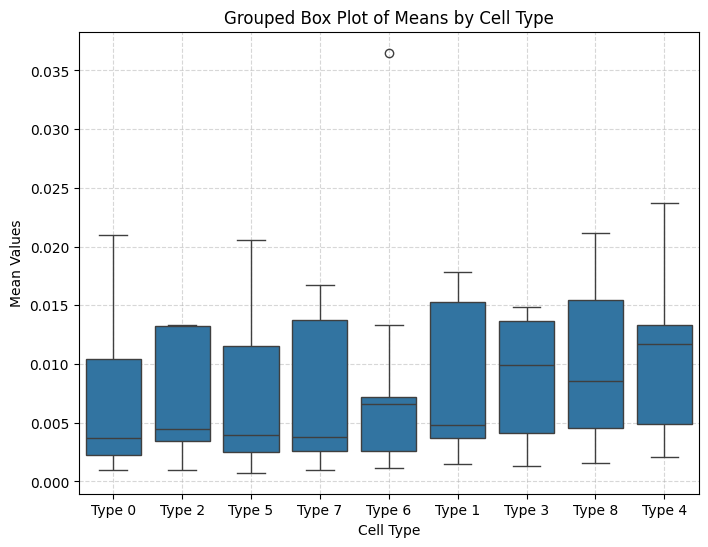

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 获取numpy数组
temp_normalized = cell_link_atten[:, map_index].cpu().numpy()

# 计算每个细胞类型组的均值
means = [np.mean(temp_normalized[cell_type_cpu == unique_celltype[i], :], axis=0) for i in range(len(unique_celltype))]

# 创建数据框并按均值排序
mean_data = {'Group': ['Type ' + str(i) for i in range(len(unique_celltype))],
             'Mean': [np.mean(m) for m in means]}
mean_df = pd.DataFrame(mean_data).sort_values(by='Mean')

# 准备用于绘图的数据
sorted_means = [means[int(group.split(' ')[1])] for group in mean_df['Group']]
data = {'Group': np.repeat(mean_df['Group'], [len(m) for m in sorted_means]),
        'Values': np.concatenate(sorted_means)}
df = pd.DataFrame(data)

# 创建箱线图
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='Values', data=df, order=mean_df['Group'])
plt.title("Grouped Box Plot of Means by Cell Type")
plt.ylabel("Mean Values")
plt.xlabel("Cell Type")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [112]:
unique_celltype

array(['B cells', 'Mast cells', 'Myeloids', 'N_Epithelial',
       'P_Epithelial', 'Plasma', 'Stromal cells', 'TNKILC',
       'T_Epithelial'], dtype=object)